# Support Vector Machines

In this lab, we'll perform a brief exploration of support vector machines (SVMs), using some of the City of Chicago data that we've seen in previous labs. Note that SVMs refer to a set of classifiers that include:
* Maximum Margin Separator
* Support Vector Classifier
* Suppor Vector Machine

The first two types of classifiers are linear classifiers, much like the ones we've seen in previous labs. The support vector machine classifier allows for non-linear decision boundaries. 

We'll first explore a linear support vector classifier on the data, and then aim to improve on that classifier by allowing for non-linear decision boundaries.

In [1]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import the Chicago Crime Data

Let's revisit the crime data that we've been exploring in some of our previous labs, and clean it up as before.


In [3]:
df = pd.read_csv("../data/chicago-crimes-2019.csv.gz", compression='gzip')
df = df.sample(frac=0.02, replace=False, random_state=1)

df.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
62365,11851289,JC461037,10/05/2019 01:00:00 AM,038XX W MADISON ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,True,...,28.0,26.0,02,1150898.0,1899740.0,2019,10/12/2019 04:05:42 PM,41.880779,-87.721377,"(41.880779076, -87.721377025)"


## Transform Features

In [4]:
print("Found {} NaN community area records.".format(df['Community Area'].isna().sum()))

# There are 4 records in the dataset with NaN Community Area... might not show up in the sample.
df.dropna(inplace=True)
df['Community Area'] = df['Community Area'].astype(float)

Found 0 NaN community area records.


## Support Vector Machines

In the lab on logistic regression, we performed a significant amount of feature engineering to try to establish a linear relationship between features and probability of arrest that we could map into a logistic regression classifier. 

In this lab, we will explore whether the ability of SVMs to capture high-dimensional relationships---as well as non-linear relationships between features and targets---allows us to more accurately predict whether an arrest occurs from the dataset.

In [5]:
target = df['Arrest'].astype(float)
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

features = df.loc[:,['Primary Type', 'Domestic', 'Community Area','Location Description','Hour']]
features2d = df.loc[:,['Community Area', 'Hour']]
features.head(1)

,Primary Type,Domestic,Community Area,Location Description,Hour
62365,CRIM SEXUAL ASSAULT,True,26.0,APARTMENT,1


### Label Encoding

Since we have a set of categorical features, we need to take non-numerical values and convert them to numbers using a LabelEncoder.

It is possible to call a LabelEncoder for each column so that category names can later be recovered, but for the sake of conciseness, we simply apply the label encoder to all columns using `apply`.

In [6]:
# Convert Categorical Features to Numerical Values
features = features.apply(LabelEncoder().fit_transform)
features.head(10)

,Primary Type,Domestic,Community Area,Location Description,Hour
62365,5,1,25,12,1
171879,9,0,1,12,15
145715,28,0,66,79,1
38006,6,0,48,68,15
237592,20,0,0,12,3
149765,27,0,29,82,17
177946,20,1,39,82,14
77056,2,0,42,82,21
23050,27,0,7,48,19
108987,27,0,40,63,12


### One Hot Encoding

The problem with label encoding is that the SVM might incorrectly infer that there is some ordering associated with the numbers assigned to each category, when in fact no such relationship exists.

To handle this effect, we use a technique called "one hot encoding", which takes each value that a feature could take and creates a column for that value. If the category takes on that value, then the column is '1', otherwise, the column is zero.

In [7]:
# Create a Pipeline.
# All steps except the last one must call 'fit_transform'
# The last step must call 'fit'
lsvc = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('svc', LinearSVC(C=1.0,max_iter=100000, class_weight='balanced')),
])

svc = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('svc', SVC(kernel='rbf', random_state=0, gamma=0.5, C=1.0, class_weight='balanced')),
])

### Evaluating the Classifier

We use 5-fold cross validation to evaluate the classifier accuracy, for a number of classifiers. We start with the linear classifier on two features only, then use the classifier with five features.  Next we try the classifier with the radial basis function.

In [8]:
# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=23)

#### Linear Classifier, 2 Features

In [11]:
cv_results = cross_val_score(lsvc,
                             features2d,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.590215070295017

#### Radial Basis Classifier, 2 Features

In [12]:
cv_results = cross_val_score(svc,
                             features2d,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.605997331313787

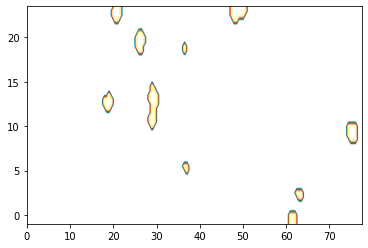

In [13]:
X = features2d.values
Y = target.values

# SVM regularization parameter: Penalty for misclassification
C = 1  
clf = SVC(kernel = 'rbf',  gamma=0.5, C=C )
clf.fit(X, Y)

h = 0.5  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

#### Linear Classifier, 5 Features

In [14]:
cv_results = cross_val_score(lsvc,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.7879986941279413

#### Radial Basis Classifier, 5 Features

In [15]:
cv_results = cross_val_score(svc,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.8415819652994868